# Load Data

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms

# Misc
import time
from datetime import datetime

# preprocessing 
import av
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from model_fns import train
from models import CNN_LSTM, ResNet_LSTM, VGG_LSTM, CRNN, CNN_GRU

# view model info

# UNCOMMENT FOR PIP VERSION
from torchinfo import summary

# # UNCOMMENT FOR CONDA VERSION
# from pytorch_model_summary import summary

In [2]:
import logging
from torch.utils.tensorboard import SummaryWriter
log_path = "log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "runs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('signo-lingo')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

Logging to file...


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
data_dir = "../scratch/AUTSL_dataset"
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

In [5]:
# All labels
filtered_data = "data"
train_label_df = pd.read_csv(f'{filtered_data}/train.csv', header=None)
test_label_df = pd.read_csv(f'{filtered_data}/test.csv', header=None)
val_label_df = pd.read_csv(f'{filtered_data}/val.csv', header=None)

In [6]:
# Total label + turkish to english translation

total_label = pd.read_csv(f'{filtered_data}/filtered_ClassId.csv')
n_classes = len(total_label['ClassId'].unique())
print("total unique label:", n_classes)


total unique label: 10


# Preprocessing

In [7]:
def extract_frames(vid_path, transforms=None, frames_cap=None): 
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        if frames_cap:
            remainder = n_frames % frames_cap
            interval = n_frames // frames_cap
            take_frame_idx = 0
            if interval < 1:
                raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
        for frame_no, frame in enumerate(container.decode(stream)):
            if frames_cap and frame_no != take_frame_idx:
                continue
#             if frame_no == take_frame_idx:
            img = frame.to_image()
            if transforms:
                img = transforms(img)
            vid_arr.append(np.array(img))
            if frames_cap:
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    return vid_arr

In [8]:
# mask rbg image
def masking(rbg_arr, depth_arr):
    """
    input
        - path for rbg
        - path for depth
    output
        - array of numpy arrays
    """

    # display - correct color orientation
    overlay_arr = []
    for i in range(len(rbg_arr)):
        # c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2RGB)
        c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2GRAY)

        gray = cv2.cvtColor(depth_arr[i], cv2.COLOR_BGR2GRAY)
        overlay = cv2.bitwise_and(c,c, mask= gray)
        overlay_arr.append(overlay)
    
    overlay_np_arr = np.array(overlay_arr)
    # print(overlay_np_arr.shape)
    overlay_np_arr = np.moveaxis(overlay_np_arr, -1, 1)
    # print(overlay_np_arr.shape)
    return overlay_np_arr

# Custom Dataset

In [9]:
class Turkish_Dataset(Dataset):
    def __init__(self, df, data_dir, n_classes, file_ext=".mp4", transforms=None, frames_cap=None):
        self.df = df
        self.frames_cap = frames_cap
        self.transforms = transforms
        self.file_ext = file_ext
        self.data_dir = data_dir
        self.n_classes = n_classes
    
    def __getitem__(self, index):

        vid_name = self.df.iloc[index, 0]
        vid_label = self.df.iloc[index, 1]
        
        vid_color = f"{self.data_dir}/{vid_name}_color{self.file_ext}"
        # vid_depth = f"{self.data_dir}/{vid_name}_depth{self.file_ext}"

        # get videos
        rgb_arr = extract_frames(vid_color, transforms=self.transforms, frames_cap=self.frames_cap) # self.frames_cap, 
        # depth_arr = extract_frames(vid_depth, self.frames_cap, transforms=self.transforms)

        vid_arr = np.array(rgb_arr)

        # vid_arr = np.stack((rgb_arr, depth_arr))
#         vid_arr = np.moveaxis(vid_arr, -1, 1)
        vid_arr = vid_arr / 255
        
        # preprocessing
        # vid_arr = masking(rgb_arr, depth_arr)
        # print(vid_arr.shape)
        
        # create one-hot-encoding for label
        label = np.zeros(self.n_classes)
        label[vid_label] = 1
        
        # convert arr to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).long().argmax()
        
        # return masked video array and label
        return vid_arr, label
    
    def __len__(self):
        return len(self.df)
#         return 10

In [10]:
n_frames = 30
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])
                                         #transforms.CenterCrop(200)])#, transforms.Grayscale()])

shape of first array torch.Size([30, 3, 256, 256])


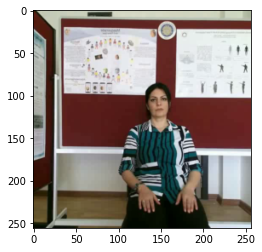

In [11]:
# Create train dataset

ld_train = Turkish_Dataset(train_label_df, train_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_train[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_train[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
# img_np_arr *= 255 # [0, 255] range

plt.imshow(img_np_arr.transpose(1, 2, 0))#.astype('uint8'))
plt.show()

In [12]:
# # UNCOMMENT TO SEE SAMPLED FRAMES
# nrows, ncols = 6, 5
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# for i in range(n_frames):
#     row_idx = i // ncols
#     col_idx = i % ncols
#     ax[row_idx][col_idx].imshow(ld_train[0][0][i].numpy().transpose(1, 2, 0))

# # # UNCOMMENT TO SAVE PLOT
# # plt.savefig('train_30_0.png')

# plt.show()

shape of first array torch.Size([30, 3, 256, 256])


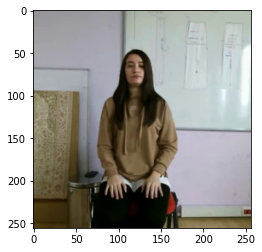

In [13]:
# Create test dataset

ld_test = Turkish_Dataset(test_label_df, test_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_test[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))#.astype('uint8'))
plt.show()

shape of first array torch.Size([30, 3, 256, 256])


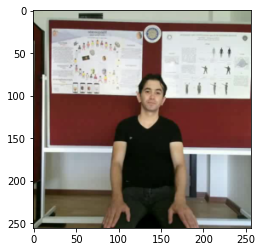

In [14]:
# Create val dataset

ld_val = Turkish_Dataset(val_label_df, val_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_val[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_val[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))#.astype('uint8'))
plt.show()

# Custom Dataloader

In [15]:
bs_train = 4
bs_test = 4
bs_val = 4
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

# Model Exploration

## No. of Conv Layers in CNN

### 3 layers

In [16]:
model = CNN_LSTM(n_classes, 
                 latent_size=512, 
                 n_cnn_layers=3, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True)

In [17]:
model

CNN_LSTM(
  (CNN): CNN(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (conv2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(128, eps=1e-05, m

In [18]:
# UNCOMMENT FOR PIP VERSION (torchinfo)
summary(model, input_size=(1, 30, 3, 256, 256))

# # UNCOMMENT FOR CONDA VERSION (pytorch_model_summary)
# summary(model, torch.zeros((1, 30, 3, 256, 256)), show_input=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─CNN: 1-1                               [30, 512]                 --
|    └─Conv2d: 2-1                       [30, 64, 127, 127]        1,792
|    └─Sequential: 2-2                   [30, 64, 61, 61]          --
|    |    └─ConvBlock: 3-1               [30, 64, 61, 61]          74,112
|    └─ConvBlock: 2-3                    [30, 128, 1, 1]           --
|    |    └─Conv2d: 3-2                  [30, 128, 59, 59]         73,856
|    |    └─BatchNorm2d: 3-3             [30, 128, 59, 59]         256
|    |    └─ReLU: 3-4                    [30, 128, 59, 59]         --
|    |    └─Conv2d: 3-5                  [30, 128, 57, 57]         147,584
|    |    └─BatchNorm2d: 3-6             [30, 128, 57, 57]         256
|    |    └─ReLU: 3-7                    [30, 128, 57, 57]         --
|    |    └─AdaptiveAvgPool2d: 3-8       [30, 128, 1, 1]           --
|    └─Linear: 2-4                       [30, 512]                 

In [19]:
if torch.cuda.device_count() > 1:
    logger.info("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [20]:
# Hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/cnn_lstm2_512_3_1_512"

In [21]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr, 
      use_scheduler=True)

######################Training Started######################
Epoch 1
100%|██████████| 311/311 [05:34<00:00,  1.08s/batch, accuracy=0, loss=2.32]   
Average Training Loss of Epoch 1: 2.306807 | Acc: 8.69%
100%|██████████| 49/49 [00:48<00:00,  1.02batch/s, accuracy=0.5, loss=2.26] 
Average Validation Loss of Epoch 1: 2.302974 | Acc: 10.31%
####################Epoch 1 Model Saved#####################
Epoch 2
100%|██████████| 311/311 [05:33<00:00,  1.07s/batch, accuracy=0, loss=2.31]   
Average Training Loss of Epoch 2: 2.305804 | Acc: 8.21%
100%|██████████| 49/49 [00:46<00:00,  1.05batch/s, accuracy=0, loss=2.32]   
Average Validation Loss of Epoch 2: 2.303819 | Acc: 9.79%
####################Epoch 2 Model Saved#####################
Increment early stopper to 1 because val loss (2.303819179534912) is greater than threshold (2.3029741170455)
Epoch 3
100%|██████████| 311/311 [05:30<00:00,  1.06s/batch, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 3: 2.305286 | Acc: 8.61%
100%|██

Epoch     5: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 311/311 [05:33<00:00,  1.07s/batch, accuracy=0.333, loss=2.28]
Average Training Loss of Epoch 6: 2.301897 | Acc: 10.78%
100%|██████████| 49/49 [00:48<00:00,  1.00batch/s, accuracy=0, loss=2.31]   
Average Validation Loss of Epoch 6: 2.302148 | Acc: 8.76%
####################Epoch 6 Model Saved#####################
Epoch 7
100%|██████████| 311/311 [05:37<00:00,  1.09s/batch, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 7: 2.301127 | Acc: 10.94%
100%|██████████| 49/49 [00:48<00:00,  1.00batch/s, accuracy=0, loss=2.32]   
Average Validation Loss of Epoch 7: 2.302239 | Acc: 10.31%
####################Epoch 7 Model Saved#####################
Increment early stopper to 1 because val loss (2.302239160148465) is greater than threshold (2.302148332401198)
Epoch 8
100%|██████████| 311/311 [05:35<00:00,  1.08s/batch, accuracy=0.333, loss=2.3]
Average Training Loss of Epoch 8: 2.302370 | Acc: 10.62%
100%|██████████| 49/49 [00:49<00:00,  1.00s/batch, accuracy=0, loss=2.

Epoch    10: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 311/311 [05:40<00:00,  1.09s/batch, accuracy=0.333, loss=2.31]
Average Training Loss of Epoch 11: 2.301482 | Acc: 9.90%
100%|██████████| 49/49 [00:47<00:00,  1.03batch/s, accuracy=0, loss=2.31]   
Average Validation Loss of Epoch 11: 2.302010 | Acc: 10.31%
####################Epoch 11 Model Saved####################
Epoch 12
100%|██████████| 311/311 [05:39<00:00,  1.09s/batch, accuracy=0.333, loss=2.31]
Average Training Loss of Epoch 12: 2.301519 | Acc: 11.34%
100%|██████████| 49/49 [00:49<00:00,  1.02s/batch, accuracy=0, loss=2.31]   
Average Validation Loss of Epoch 12: 2.302022 | Acc: 8.76%
####################Epoch 12 Model Saved####################
Increment early stopper to 1 because val loss (2.302022170047371) is greater than threshold (2.302010249118416)
Epoch 13
100%|██████████| 311/311 [05:43<00:00,  1.11s/batch, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 13: 2.300847 | Acc: 10.46%
100%|██████████| 49/49 [00:49<00:00,  1.02s/batch, accuracy=0, 

Epoch    14: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 311/311 [05:47<00:00,  1.12s/batch, accuracy=0, loss=2.28]   
Average Training Loss of Epoch 15: 2.301078 | Acc: 10.94%
100%|██████████| 49/49 [00:49<00:00,  1.01s/batch, accuracy=0.5, loss=2.3]  
Average Validation Loss of Epoch 15: 2.301900 | Acc: 8.76%
####################Epoch 15 Model Saved####################
Epoch 16
100%|██████████| 311/311 [05:46<00:00,  1.11s/batch, accuracy=0, loss=2.29]   
Average Training Loss of Epoch 16: 2.301203 | Acc: 10.54%
100%|██████████| 49/49 [00:50<00:00,  1.02s/batch, accuracy=0, loss=2.28]   
Average Validation Loss of Epoch 16: 2.301657 | Acc: 8.76%
####################Epoch 16 Model Saved####################
Epoch 17
100%|██████████| 311/311 [05:47<00:00,  1.12s/batch, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 17: 2.301125 | Acc: 10.22%
100%|██████████| 49/49 [00:49<00:00,  1.01s/batch, accuracy=0, loss=2.31]   
Average Validation Loss of Epoch 17: 2.302038 | Acc: 8.76%
####################Epoch 17 Model Saved#

CNN_LSTM(
  (CNN): CNN(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (conv2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(128, eps=1e-05, m

### 5 layers

In [16]:
model = CNN_LSTM(n_classes, 
                 latent_size=512, 
                 n_cnn_layers=5, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True)

In [17]:
# UNCOMMENT FOR PIP VERSION (torchinfo)
summary(model, input_size=(1, 30, 3, 256, 256))

# # UNCOMMENT FOR CONDA VERSION (pytorch_model_summary)
# summary(model, torch.zeros((1, 30, 3, 256, 256)), show_input=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─CNN_Encoder: 1-1                       [30, 512]                 --
|    └─Conv2d: 2-1                       [30, 64, 127, 127]        1,792
|    └─Sequential: 2-2                   [30, 256, 12, 12]         --
|    |    └─ConvBlock: 3-1               [30, 64, 61, 61]          74,112
|    |    └─ConvBlock: 3-2               [30, 128, 28, 28]         221,952
|    |    └─ConvBlock: 3-3               [30, 256, 12, 12]         886,272
|    └─ConvBlock: 2-3                    [30, 512, 1, 1]           --
|    |    └─Conv2d: 3-4                  [30, 512, 10, 10]         1,180,160
|    |    └─BatchNorm2d: 3-5             [30, 512, 10, 10]         1,024
|    |    └─ReLU: 3-6                    [30, 512, 10, 10]         --
|    |    └─Conv2d: 3-7                  [30, 512, 8, 8]           2,359,808
|    |    └─BatchNorm2d: 3-8             [30, 512, 8, 8]           1,024
|    |    └─ReLU: 3-9                    [30, 51

In [18]:
if torch.cuda.device_count() > 1:
    logger.info("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [19]:
# Hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/cnn_lstm2_512_5_1_512"

In [20]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr, 
      use_scheduler=True)

######################Training Started######################
Epoch 1
100%|██████████| 311/311 [05:09<00:00,  1.00batch/s, accuracy=0, loss=2.34]   
Average Training Loss of Epoch 1: 2.309555 | Acc: 8.85%
100%|██████████| 49/49 [00:42<00:00,  1.14batch/s, accuracy=0, loss=2.32]   
Average Validation Loss of Epoch 1: 2.304928 | Acc: 10.31%
####################Epoch 1 Model Saved#####################
Epoch 2
100%|██████████| 311/311 [05:05<00:00,  1.02batch/s, accuracy=0, loss=2.32]   
Average Training Loss of Epoch 2: 2.301474 | Acc: 10.86%
100%|██████████| 49/49 [00:42<00:00,  1.15batch/s, accuracy=0, loss=2.26]   
Average Validation Loss of Epoch 2: 2.306266 | Acc: 10.31%
####################Epoch 2 Model Saved#####################
Increment early stopper to 1 because val loss (2.306265976964211) is greater than threshold (2.304928492526619)
Epoch 3
100%|██████████| 311/311 [05:05<00:00,  1.02batch/s, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 3: 2.294804 | Acc: 12.39%
10

Epoch     5: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 311/311 [05:05<00:00,  1.02batch/s, accuracy=0.667, loss=2.18]
Average Training Loss of Epoch 6: 2.213421 | Acc: 25.74%
100%|██████████| 49/49 [00:42<00:00,  1.16batch/s, accuracy=0, loss=2.17]   
Average Validation Loss of Epoch 6: 2.341008 | Acc: 9.28%
####################Epoch 6 Model Saved#####################
Increment early stopper to 5 because val loss (2.3410075538012447) is greater than threshold (2.304928492526619)
Epoch 7
100%|██████████| 311/311 [05:05<00:00,  1.02batch/s, accuracy=0, loss=2.25]   
Average Training Loss of Epoch 7: 2.191351 | Acc: 27.19%
100%|██████████| 49/49 [00:42<00:00,  1.16batch/s, accuracy=0, loss=2.63]   
Average Validation Loss of Epoch 7: 2.325224 | Acc: 8.25%
####################Epoch 7 Model Saved#####################
Increment early stopper to 6 because val loss (2.325224088162792) is greater than threshold (2.304928492526619)
Epoch 8
100%|██████████| 311/311 [05:05<00:00,  1.02batch/s, accuracy=1, loss=2.08]   
Average Trainin

Epoch     9: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 311/311 [05:12<00:00,  1.00s/batch, accuracy=0.333, loss=2.03]
Average Training Loss of Epoch 10: 2.121360 | Acc: 30.25%
100%|██████████| 49/49 [00:42<00:00,  1.15batch/s, accuracy=0, loss=2.33]   
Average Validation Loss of Epoch 10: 2.342014 | Acc: 8.25%
####################Epoch 10 Model Saved####################
Increment early stopper to 9 because val loss (2.342013957549115) is greater than threshold (2.304928492526619)
Epoch 11
100%|██████████| 311/311 [05:06<00:00,  1.02batch/s, accuracy=0.667, loss=2]  
Average Training Loss of Epoch 11: 2.124585 | Acc: 28.96%
100%|██████████| 49/49 [00:42<00:00,  1.16batch/s, accuracy=0, loss=2.26]   
Average Validation Loss of Epoch 11: 2.337740 | Acc: 6.19%
####################Epoch 11 Model Saved####################
Increment early stopper to 10 because val loss (2.3377399152638962) is greater than threshold (2.304928492526619)
Model has overfit, early stopping...
#####################Training Finished#####################

CNN_LSTM(
  (encoder): CNN_Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(128, 

# Other experiments below

#### w weight decay

In [16]:
model = CNN_LSTM(n_classes, 
                 latent_size=512, 
                 n_cnn_layers=5, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True)

In [17]:
summary(model, input_size=(1, 30, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─CNN_Encoder: 1-1                       [30, 512]                 --
|    └─Conv2d: 2-1                       [30, 64, 127, 127]        1,792
|    └─Sequential: 2-2                   [30, 64, 61, 61]          --
|    |    └─ConvBlock: 3-1               [30, 64, 61, 61]          74,112
|    └─ConvBlock: 2-3                    [30, 128, 1, 1]           --
|    |    └─Conv2d: 3-2                  [30, 128, 59, 59]         73,856
|    |    └─BatchNorm2d: 3-3             [30, 128, 59, 59]         256
|    |    └─ReLU: 3-4                    [30, 128, 59, 59]         --
|    |    └─Conv2d: 3-5                  [30, 128, 57, 57]         147,584
|    |    └─BatchNorm2d: 3-6             [30, 128, 57, 57]         256
|    |    └─ReLU: 3-7                    [30, 128, 57, 57]         --
|    |    └─AdaptiveAvgPool2d: 3-8       [30, 128, 1, 1]           --
|    └─Linear: 2-4                       [30, 512]                 

In [22]:
# Hyperparams
no_of_epochs = 30
optimizer_lr = 1e-5
weight_decay = 1e-5
save_dir = "saved_models/cnn_lstm2_512_3_1_512_weightd"

In [ ]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr, 
      weight_decay=weight_decay)

######################Training Started######################
Epoch 1
100%|██████████| 311/311 [05:29<00:00,  1.06s/batch, accuracy=0, loss=2.32]   
Average Training Loss of Epoch 1: 2.307093 | Acc: 9.65%
100%|██████████| 49/49 [00:47<00:00,  1.04batch/s, accuracy=0, loss=2.29]   
Average Validation Loss of Epoch 1: 2.302886 | Acc: 10.31%
####################Epoch 1 Model Saved#####################
Epoch 2
100%|██████████| 311/311 [05:28<00:00,  1.06s/batch, accuracy=0.333, loss=2.3]
Average Training Loss of Epoch 2: 2.305597 | Acc: 9.17%
100%|██████████| 49/49 [00:46<00:00,  1.04batch/s, accuracy=0, loss=2.31]   
Average Validation Loss of Epoch 2: 2.303744 | Acc: 10.31%
####################Epoch 2 Model Saved#####################
Increment early stopper to 1 because val loss (2.3037443258324446) is greater than threshold (2.3028860919329586)
Epoch 3
100%|██████████| 311/311 [05:29<00:00,  1.06s/batch, accuracy=0, loss=2.31]   
Average Training Loss of Epoch 3: 2.305223 | Acc: 8.85%
10

### GRU

In [ ]:
from models import CNN_GRU

In [ ]:
model = CNN_GRU(n_classes, 
                 latent_size=512, 
                 n_cnn_layers=3, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True)

In [ ]:
summary(model, input_size=(1, 30, 3, 256, 256))

In [ ]:
# Hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/cnn_gru_512_3_1_512"

In [ ]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr)

### RNN

In [17]:
if torch.cuda.device_count() > 1:
    logger.info("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [18]:
# Hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/cnn_lstm_7_3_1_512"
# save_dir = "saved_models/cnn_lstm_test"
# sample_size = 128
# sample_duration = 16
# num_classes = 100
# lstm_hidden_size = 512
# lstm_num_layers = 1
# attention = False

In [19]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr)

######################Training Started######################
Epoch 1
100%|██████████| 1243/1243 [08:17<00:00,  2.50batch/s, accuracy=0, loss=2.32]
Average Training Loss of Epoch 2: 2.311381 | Acc: 9.81%
100%|██████████| 194/194 [00:54<00:00,  3.55batch/s, accuracy=0, loss=2.31]
Average Validation Loss of Epoch 2: 2.306467 | Acc: 9.79%
####################Epoch 1 Model Saved#####################
Epoch 2
100%|██████████| 1243/1243 [08:19<00:00,  2.49batch/s, accuracy=1, loss=2.14]
Average Training Loss of Epoch 3: 2.311290 | Acc: 8.37%
100%|██████████| 194/194 [00:54<00:00,  3.56batch/s, accuracy=0, loss=2.33]
Average Validation Loss of Epoch 3: 2.306574 | Acc: 8.76%
####################Epoch 2 Model Saved#####################
Epoch 3
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 1 because val loss (2.3065741652065945) is greater than threshold (2.306467354912119)


100%|██████████| 1243/1243 [08:20<00:00,  2.48batch/s, accuracy=0, loss=2.38]
Average Training Loss of Epoch 4: 2.311438 | Acc: 9.17%
100%|██████████| 194/194 [00:55<00:00,  3.50batch/s, accuracy=0, loss=2.34]
Average Validation Loss of Epoch 4: 2.303561 | Acc: 9.79%
####################Epoch 3 Model Saved#####################
Epoch 4
100%|██████████| 1243/1243 [08:17<00:00,  2.50batch/s, accuracy=1, loss=2.03]
Average Training Loss of Epoch 5: 2.308335 | Acc: 9.90%
100%|██████████| 194/194 [00:54<00:00,  3.56batch/s, accuracy=0, loss=2.35]
Average Validation Loss of Epoch 5: 2.307190 | Acc: 9.79%
####################Epoch 4 Model Saved#####################
Epoch 5
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 1 because val loss (2.3071902068619874) is greater than threshold (2.3035611934268596)


100%|██████████| 1243/1243 [08:15<00:00,  2.51batch/s, accuracy=0, loss=2.4] 
Average Training Loss of Epoch 6: 2.309446 | Acc: 9.09%
100%|██████████| 194/194 [00:55<00:00,  3.52batch/s, accuracy=0, loss=2.35]
Average Validation Loss of Epoch 6: 2.306353 | Acc: 10.31%
####################Epoch 5 Model Saved#####################
Epoch 6
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 2 because val loss (2.3063528427143685) is greater than threshold (2.3035611934268596)


100%|██████████| 1243/1243 [08:22<00:00,  2.48batch/s, accuracy=0, loss=2.32]
Average Training Loss of Epoch 7: 2.310766 | Acc: 8.93%
100%|██████████| 194/194 [00:54<00:00,  3.57batch/s, accuracy=0, loss=2.36]
Average Validation Loss of Epoch 7: 2.302652 | Acc: 10.31%
####################Epoch 6 Model Saved#####################
Epoch 7
100%|██████████| 1243/1243 [08:15<00:00,  2.51batch/s, accuracy=1, loss=2.24]
Average Training Loss of Epoch 8: 2.311297 | Acc: 7.96%
100%|██████████| 194/194 [00:55<00:00,  3.52batch/s, accuracy=0, loss=2.33]
Average Validation Loss of Epoch 8: 2.303501 | Acc: 9.79%
####################Epoch 7 Model Saved#####################
Epoch 8
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 1 because val loss (2.303501447451483) is greater than threshold (2.302651710116986)


100%|██████████| 1243/1243 [08:16<00:00,  2.50batch/s, accuracy=1, loss=2.09]
Average Training Loss of Epoch 9: 2.307127 | Acc: 10.06%
100%|██████████| 194/194 [00:54<00:00,  3.57batch/s, accuracy=0, loss=2.39]
Average Validation Loss of Epoch 9: 2.313574 | Acc: 10.31%
####################Epoch 8 Model Saved#####################
Epoch 9
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 2 because val loss (2.3135736099223503) is greater than threshold (2.302651710116986)


100%|██████████| 1243/1243 [08:13<00:00,  2.52batch/s, accuracy=0, loss=2.31]
Average Training Loss of Epoch 10: 2.311952 | Acc: 8.29%
100%|██████████| 194/194 [00:54<00:00,  3.57batch/s, accuracy=0, loss=2.32]
Average Validation Loss of Epoch 10: 2.303765 | Acc: 10.31%
####################Epoch 9 Model Saved#####################
Epoch 10
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 3 because val loss (2.303765425977019) is greater than threshold (2.302651710116986)


100%|██████████| 1243/1243 [08:17<00:00,  2.50batch/s, accuracy=0, loss=2.25]
Average Training Loss of Epoch 11: 2.310190 | Acc: 8.85%
100%|██████████| 194/194 [00:55<00:00,  3.51batch/s, accuracy=0, loss=2.33]
Average Validation Loss of Epoch 11: 2.302614 | Acc: 9.79%
####################Epoch 10 Model Saved####################
Epoch 11
100%|██████████| 1243/1243 [08:31<00:00,  2.43batch/s, accuracy=0, loss=2.34]
Average Training Loss of Epoch 12: 2.308601 | Acc: 9.98%
100%|██████████| 194/194 [00:56<00:00,  3.43batch/s, accuracy=0, loss=2.3] 
Average Validation Loss of Epoch 12: 2.302675 | Acc: 10.31%
####################Epoch 11 Model Saved####################
Epoch 12
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 1 because val loss (2.3026751267541314) is greater than threshold (2.3026137265962423)


100%|██████████| 1243/1243 [08:23<00:00,  2.47batch/s, accuracy=0, loss=2.34]
Average Training Loss of Epoch 13: 2.309350 | Acc: 10.38%
100%|██████████| 194/194 [00:54<00:00,  3.56batch/s, accuracy=0, loss=2.29]
Average Validation Loss of Epoch 13: 2.305182 | Acc: 10.31%
####################Epoch 12 Model Saved####################
Epoch 13
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 2 because val loss (2.3051820981133844) is greater than threshold (2.3026137265962423)


100%|██████████| 1243/1243 [08:16<00:00,  2.50batch/s, accuracy=0, loss=2.34]
Average Training Loss of Epoch 14: 2.310773 | Acc: 8.05%
100%|██████████| 194/194 [00:54<00:00,  3.58batch/s, accuracy=0, loss=2.33]
Average Validation Loss of Epoch 14: 2.302495 | Acc: 10.31%
####################Epoch 13 Model Saved####################
Epoch 14
100%|██████████| 1243/1243 [08:17<00:00,  2.50batch/s, accuracy=0, loss=2.3] 
Average Training Loss of Epoch 15: 2.311000 | Acc: 9.65%
100%|██████████| 194/194 [00:55<00:00,  3.50batch/s, accuracy=0, loss=2.31]
Average Validation Loss of Epoch 15: 2.305094 | Acc: 9.79%
####################Epoch 14 Model Saved####################
Epoch 15
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 1 because val loss (2.305093926252778) is greater than threshold (2.302495033470626)


100%|██████████| 1243/1243 [08:16<00:00,  2.50batch/s, accuracy=1, loss=2.05]
Average Training Loss of Epoch 16: 2.312573 | Acc: 9.01%
100%|██████████| 194/194 [00:54<00:00,  3.57batch/s, accuracy=1, loss=2.2] 
Average Validation Loss of Epoch 16: 2.305358 | Acc: 10.31%
####################Epoch 15 Model Saved####################
Epoch 16
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 2 because val loss (2.3053582415138325) is greater than threshold (2.302495033470626)


100%|██████████| 1243/1243 [08:14<00:00,  2.52batch/s, accuracy=0, loss=2.39]
Average Training Loss of Epoch 17: 2.311398 | Acc: 7.96%
100%|██████████| 194/194 [00:54<00:00,  3.58batch/s, accuracy=0, loss=2.36]
Average Validation Loss of Epoch 17: 2.304583 | Acc: 10.31%
####################Epoch 16 Model Saved####################
Epoch 17
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 3 because val loss (2.304583432748146) is greater than threshold (2.302495033470626)


100%|██████████| 1243/1243 [08:12<00:00,  2.52batch/s, accuracy=0, loss=2.37]
Average Training Loss of Epoch 18: 2.310488 | Acc: 9.33%
100%|██████████| 194/194 [00:54<00:00,  3.53batch/s, accuracy=0, loss=2.35]
Average Validation Loss of Epoch 18: 2.304921 | Acc: 10.31%
####################Epoch 17 Model Saved####################
Epoch 18
  0%|          | 0/1243 [00:00<?, ?batch/s]

Increment early stopper to 4 because val loss (2.3049206426463176) is greater than threshold (2.302495033470626)


 65%|██████▌   | 809/1243 [05:22<02:52,  2.51batch/s, accuracy=1, loss=2.21]


KeyboardInterrupt: 

In [20]:
model_1 = CRNN(num_classes=n_classes)

In [21]:
summary(model_1, input_size=(1, 30, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 64, 62, 62]           --
|    └─Conv2d: 2-1                       [1, 64, 125, 125]         9,472
|    └─BatchNorm2d: 2-2                  [1, 64, 125, 125]         128
|    └─ReLU: 2-3                         [1, 64, 125, 125]         --
|    └─Conv2d: 2-4                       [1, 64, 125, 125]         4,160
|    └─MaxPool2d: 2-5                    [1, 64, 62, 62]           --
├─Sequential: 1-2                        [1, 128, 30, 30]          --
|    └─Conv2d: 2-6                       [1, 128, 60, 60]          73,856
|    └─BatchNorm2d: 2-7                  [1, 128, 60, 60]          256
|    └─ReLU: 2-8                         [1, 128, 60, 60]          --
|    └─Conv2d: 2-9                       [1, 128, 60, 60]          16,512
|    └─MaxPool2d: 2-10                   [1, 128, 30, 30]          --
├─Sequential: 1-3                        [1, 256, 14, 14]          --

In [20]:
# Hyperparams
epochs = 30
# batch_size = 4
learning_rate = 1e-5
weight_decay = 1e-5
log_interval = 20
# sample_size = 128
# sample_duration = 16
# num_classes = 100
# lstm_hidden_size = 512
# lstm_num_layers = 1
# attention = False

In [18]:
model = CRNN(num_classes=u_len_label).to(device)

In [19]:
if torch.cuda.device_count() > 1:
    logger.info("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [21]:
# Start training
logger.info("Training Started".center(60, '#'))
for epoch in range(epochs):
    logger.info(f"Epoch {epoch+1}")
    
    # Train the model
    train_epoch(model, criterion, optimizer, train_loader, device, epoch, logger, log_interval, writer)

    # Validate the model
    val_epoch(model, criterion, val_loader, device, epoch, logger, writer)

    # Save model
    torch.save(model.state_dict(), os.path.join("saved_models/slr_convlstm2_epoch{:03d}.pth".format(epoch+1)))
    logger.info("Epoch {} Model Saved".format(epoch+1).center(60, '#'))

logger.info("Training Finished".center(60, '#'))

######################Training Started######################
Epoch 0
100%|██████████| 311/311 [05:31<00:00,  1.07s/batch, accuracy=0, loss=2.34]   
Average Training Loss of Epoch 1: 2.309455 | Acc: 7.48%
Average Validation Loss of Epoch 1: 2.302975 | Acc: 6.70%
####################Epoch 1 Model Saved#####################
Epoch 1
100%|██████████| 311/311 [05:31<00:00,  1.07s/batch, accuracy=0, loss=2.3]    
Average Training Loss of Epoch 2: 2.306907 | Acc: 7.88%
Average Validation Loss of Epoch 2: 2.302246 | Acc: 9.79%
####################Epoch 2 Model Saved#####################
Epoch 2
100%|██████████| 311/311 [05:32<00:00,  1.07s/batch, accuracy=0.333, loss=2.27]
Average Training Loss of Epoch 3: 2.305091 | Acc: 9.25%
Average Validation Loss of Epoch 3: 2.302334 | Acc: 9.79%
####################Epoch 3 Model Saved#####################
Epoch 3
100%|██████████| 311/311 [05:33<00:00,  1.07s/batch, accuracy=0, loss=2.29]   
Average Training Loss of Epoch 4: 2.303278 | Acc: 9.09%
Average V

In [ ]:
model = CRNN(num_classes=u_len_label)

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      no_of_epochs=10, 
                                                                                                      device=device, 
                                                                                                      save_dir="saved_models/crnn", 
                                                                                                      lr_scheduler=True)

## CNN-LSTM (with dropout)

In [ ]:
model = CNN_LSTM(u_len_label, 300, 2, 2, channel_in=3, cnn_bn=True, bidirectional=True)

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      no_of_epochs=10, 
                                                                                                      device=device, 
                                                                                                      save_dir="saved_models/cnn_lstm_dropout", 
                                                                                                      lr_scheduler=True)

## CNN-LSTM (from scratch)

In [ ]:
model = CNN_RNN(u_len_label, 30, 2, 2, channel_in=3, cnn_bn=True, bidirectional=True)

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      no_of_epochs=10, 
                                                                                                      device=device, 
                                                                                                      save_dir="saved_models/cnn_rnn_bn_bidir", 
                                                                                                      lr_scheduler=True)

## CNN-LSTM (VGG11)

In [ ]:
model = VGG_LSTM(u_len_label, 300, 2, bidirectional=True)

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      no_of_epochs=10, 
                                                                                                      device=device, 
                                                                                                      save_dir="saved_models/vgg_lstm_bidir", 
                                                                                                      lr_scheduler=True)

## CNN-LSTM (ResNet101)

In [ ]:
model = ResNet_LSTM(u_len_label, 300, resnet_opt="resnet101")

In [ ]:
train_loss_store, train_acc_store, val_loss_store, val_acc_store, val_metrics_store = model_fns.train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      no_of_epochs=10, 
                                                                                                      device=device, 
                                                                                                      save_dir="saved_models/cnn_lstm_101", 
                                                                                                      lr_scheduler=True)

# Graph

In [24]:
# UNCOMMENT TO CLEAR GPU CACHE
import gc
gc.collect()
torch.cuda.empty_cache()